## LDA and Document Similarity

We are working fake news articles supplied by Kaggle. We will train an LDA model on this corpus of fake news to see what topics emerge.

In [1]:
# import dependencies
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.models import LdaModel 
from gensim import models, corpora, similarities
import re
from nltk.stem.porter import PorterStemmer
import time
from nltk import FreqDist
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [3]:
df = pd.read_csv('fake.csv', usecols = ['uuid','author','title','text','language','site_url','country'])
df = df[df.language == 'english']
df = df[df.text.map(type) == str]
df.title.fillna('', inplace = True)
df.dropna(axis=0, inplace=True, subset=['text'])
#shuffling the dataset
df = df.sample(frac=1.0)
df.reset_index(drop=True,inplace=True)
df.head()

,uuid,author,title,text,language,site_url,country
0,0f5065318e26607b5284254e1b5dbeeecc24433e,Editor,The Pleiadian Video That Triggered My Kundalin...,Awakening Our Truth: This video forced me to q...,english,theeventchronicle.com,US
1,d02c774f3cfbd9a58ac425ebed784da28bc4d7e9,NaN,Fox News Just Exposed Hillary’s ILLEGAL VOTING...,Home / News / Fox News Just Exposed Hillary’s ...,english,departed.co,US
2,b23c68b588679f3b2ac663e6a9f4fd915fc89fcb,Scott Buss,"Hope, Change, Lies and Greatness",One of the themes of this election cycle in Am...,english,freedomoutpost.com,US
3,085bf8677085aecc02a1dd01fd6c1cbb6186d852,NaN,Reduce Nurse Burnout by Treating Nurses as Wel...,Prev post Page 1 of 4 Next \nNurses are among ...,english,undergroundhealth.com,BG
4,08aacc219b96583768b322ce7e2ee9e9294948e9,IWB,Bank of Canada Commentary Whipsaws Loonie,Bank of Canada Commentary Whipsaws Loonie \n...,english,investmentwatchblog.com,US


In [5]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

def initial_clean(text):
    # Function to clean text of websites, email addresess and any punctuation. We also lower case the text
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower() # lower case the text
    text = nltk.word_tokenize(text)
    return text

stop_words = stopwords.words('english')
def remove_stop_words(text):
    # Function that removes all stopwords from text
    return [word for word in text if word not in stop_words]

stemmer = nltk.WordNetLemmatizer()
def stem_words(text):
    # Function to stem words, so plural and singular are treated the same
    try:
        text = [stemmer.lemmatize(word) for word in text]
        text = [word for word in text if len(word) > 1] # make sure we have no 1 letter words
    except IndexError:
        pass
    return text

def apply_all(text):
    return stem_words(remove_stop_words(initial_clean(text)))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pundeer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Pundeer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Pundeer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
t1 = time.time()
df['tokenized'] = df['text'].apply(apply_all) + df['title'].apply(apply_all)
t2 = time.time()
print("Time to clean and tokenize", len(df), "articles:", (t2-t1)/60, "min")

Time to clean and tokenize 12357 articles: 5.172296452522278 min


***Using word frequency to filter only top used words***

In [7]:
all_words = [word for item in list(df['tokenized']) for word in item]
fdist = FreqDist(all_words)
len(fdist) # number of unique words

116512

In [8]:
k = 20000
top_k_words = fdist.most_common(k)
top_k_words[-10:]

[('succumbing', 12),
 ('reenter', 12),
 ('antius', 12),
 ('rerouting', 12),
 ('pigeon', 12),
 ('markle', 12),
 ('speculates', 12),
 ('councillor', 12),
 ('taunting', 12),
 ('endeavour', 12)]

In [9]:
top_k_words,_ = zip(*fdist.most_common(k))
top_k_words = set(top_k_words)
def keep_top_k_words(text):
    return [word for word in text if word in top_k_words]

In [10]:
df['tokenized'] = df['tokenized'].apply(keep_top_k_words)

In [11]:
doc_len = df.tokenized.apply(lambda x : len(x))
print(len(doc_len), np.mean(doc_len), min(doc_len), max(doc_len))

12357 339.998381484179 0 11405


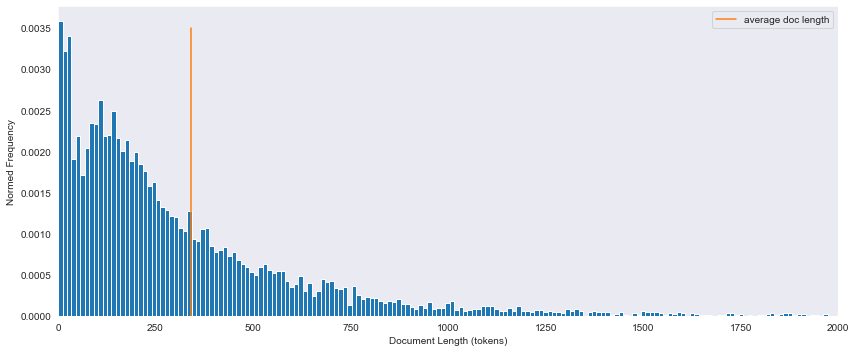

In [12]:
fig, ax = plt.subplots(figsize = (12,5))
# the histogram of the data
ax.hist(doc_len, 1000, density=True)
ax.set_xlabel('Document Length (tokens)')
ax.set_ylabel('Normed Frequency')
plt.xlim(0,2000)
ax.plot([np.average(doc_len) for i in np.linspace(0.0,0.0035,100)], np.linspace(0.0,0.0035,100), '-',
         label='average doc length')
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

### Dropping short articles

LDA does not work very well on short documents, which we will explain later, so we will drop some of the shorter articles here before training the model.

In [13]:
# Only keeping articles with more than 50 tokens
df = df[df.tokenized.map(len) >= 50]
df = df[df.tokenized.map(type) == list]
df.reset_index(drop=True, inplace = True)
len(df)

10540

In [14]:
df.head()

,uuid,author,title,text,language,site_url,country,tokenized
0,0f5065318e26607b5284254e1b5dbeeecc24433e,Editor,The Pleiadian Video That Triggered My Kundalin...,Awakening Our Truth: This video forced me to q...,english,theeventchronicle.com,US,"[awakening, truth, video, forced, question, be..."
1,d02c774f3cfbd9a58ac425ebed784da28bc4d7e9,NaN,Fox News Just Exposed Hillary’s ILLEGAL VOTING...,Home / News / Fox News Just Exposed Hillary’s ...,english,departed.co,US,"[home, news, fox, news, exposed, hillary, ille..."
2,b23c68b588679f3b2ac663e6a9f4fd915fc89fcb,Scott Buss,"Hope, Change, Lies and Greatness",One of the themes of this election cycle in Am...,english,freedomoutpost.com,US,"[one, theme, election, cycle, america, clarity..."
3,085bf8677085aecc02a1dd01fd6c1cbb6186d852,NaN,Reduce Nurse Burnout by Treating Nurses as Wel...,Prev post Page 1 of 4 Next \nNurses are among ...,english,undergroundhealth.com,BG,"[prev, post, page, next, nurse, among, profess..."
4,08aacc219b96583768b322ce7e2ee9e9294948e9,IWB,Bank of Canada Commentary Whipsaws Loonie,Bank of Canada Commentary Whipsaws Loonie \n...,english,investmentwatchblog.com,US,"[bank, canada, commentary, last, two, week, we..."


##### Splitting the dataset into training and testing set

In [15]:
msk = np.random.rand(len(df)) < 0.9

train_df = df[msk]
train_df.reset_index(drop=True,inplace=True)

test_df = df[~msk]
test_df.reset_index(drop=True,inplace=True)
print(len(train_df), len(test_df))

9510 1030


### LDA
Latent Dirichlet Allocation, is an unsupervised generative model that assigns topic distributions to documents. There a several ways to implement LDA, however I will speak about collapsed gibbs sampling as I usually find this to be the easiest way to understand it.

The model initialises by assigning every word in every document to a random topic. Then, we iterate through each word, unassign it's current topic, decrement the topic count corpus wide and reassign the word to a new topic based on the local probability of topic assignemnts to the current document, and the global (corpus wide) probability of the word assignments to the current topic. This may be hard to understand in words, so the equations are below.

#### The mathematics of collapsed gibbs sampling (cut back version)

Recall that when we iterate through each word in each document, we unassign its current topic assignment and reassign the word to a new topic. The topic we reassign the word to is based on the probabilities below.

$$
P\left(\text{document "likes" the topic}\right) \times P\left(\text{topic "likes" the word } w'\right)
$$

$$
\Rightarrow \frac{n_{i,k}+\alpha}{N_i-1+K\alpha} \times \frac{m_{w',k}+\gamma}{\sum_{w\in V}m_{w,k} + V\gamma}
$$

where

$n_{i,k}$ - number of word assignments to topic $k$ in document $i$

$n_{i,k}$ - number of assignments to topic $k$ in document $i$

$\alpha$ - smoothing parameter (hyper parameter - make sure probability is never 0)

$N_i$ - number of words in document $i$

$-1$ - don't count the current word you're on

$K$ - total number of topics


$m_{w',k}$ - number of assignments, corpus wide, of word $w'$ to topic $k$

$m_{w',k}$ - number of assignments, corpus wide, of word $w'$ to topic $k$

$\gamma$ - smoothing parameter (hyper parameter - make sure probability is never 0)

$\sum_{w\in V}m_{w,k}$ - sum over all words in vocabulary currently assigned to topic $k$

$V$ size of vocabulary i.e. number of distinct words corpus wide

In [16]:
def train_lda(data):
    #We do 2 passes of the data since this is a small dataset, so we want the distributions to stabilize
    dictionary = corpora.Dictionary(data['tokenized'])
    corpus = [dictionary.doc2bow(doc) for doc in data['tokenized']]
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    lda = LdaModel(corpus = corpus, num_topics = 100, id2word = dictionary,
                   alpha = 1e-2, eta = 0.5e-2, chunksize = 300, minimum_probability = 0.0, passes = 2)
    return dictionary,corpus,lda

In [17]:
dictionary,corpus,lda = train_lda(train_df)

In [18]:
# show_topics method shows the the top num_words contributing to num_topics number of random topics
lda.show_topics(num_topics=10, num_words=20)

[(89,
  '0.249*"film" + 0.171*"movie" + 0.063*"hollywood" + 0.058*"jason" + 0.034*"industry" + 0.034*"concert" + 0.034*"actor" + 0.032*"filmmaker" + 0.025*"robert" + 0.021*"character" + 0.020*"story" + 0.018*"mentor" + 0.015*"play" + 0.014*"director" + 0.013*"awardwinning" + 0.012*"viewer" + 0.012*"predicts" + 0.012*"series" + 0.010*"yang" + 0.009*"list"'),
 (81,
  '0.046*"facebook" + 0.042*"medium" + 0.033*"news" + 0.028*"twitter" + 0.027*"social" + 0.023*"user" + 0.022*"google" + 0.022*"page" + 0.018*"information" + 0.017*"post" + 0.017*"network" + 0.015*"website" + 0.014*"account" + 0.012*"help" + 0.012*"content" + 0.011*"youtube" + 0.010*"support" + 0.010*"site" + 0.010*"automatically" + 0.009*"today"'),
 (8,
  '0.191*"black" + 0.077*"student" + 0.051*"university" + 0.031*"community" + 0.025*"college" + 0.023*"professor" + 0.020*"campus" + 0.018*"color" + 0.015*"school" + 0.013*"life" + 0.013*"matter" + 0.013*"slavery" + 0.011*"group" + 0.010*"african" + 0.009*"speech" + 0.009*"mov

In [19]:
lda.show_topic(topicid=55, topn=20)

[('blast', 0.11763519),
 ('explosion', 0.0953096),
 ('bright', 0.09349361),
 ('lebanon', 0.09206834),
 ('treasure', 0.07466613),
 ('du', 0.07369618),
 ('ka', 0.061259117),
 ('confession', 0.054497357),
 ('eyewitness', 0.043312),
 ('spine', 0.038733754),
 ('mac', 0.03577423),
 ('medieval', 0.032397076),
 ('outskirt', 0.02960012),
 ('signaling', 0.020796245),
 ('precursor', 0.020239893),
 ('shrine', 0.014286592),
 ('slavo', 0.013067778),
 ('shah', 0.006945925),
 ('complex', 0.0038769266),
 ('fuel', 0.0029780315)]

Note that if you re run the model again, as it is non-deterministic, word contributions to topics and topic ID's will change.

In [20]:
# select and article at random from train_df
random_article_index = np.random.randint(len(train_df))
bow = dictionary.doc2bow(train_df.iloc[random_article_index,7])
print(random_article_index)

7860


In [21]:
print(train_df.iloc[random_article_index,3])

Scotland warns of no access to EU single market after Brexit Scotland warns of no access to EU single market after Brexit By 0 149 
Scottish Secretary of State David Mundell has warned about the consequences of the UK’s withdrawal from the European Union (EU), saying Brexit would cut access to the single market. 
Mundell told members of the Scottish Parliament on Thursday that neither Scotland nor any other part of the UK was going to get a “special deal” during the negotiations with the EU. 
“So there are very specific issues to specific industries, but there won’t be special deals and it’s absolutely wrong to characterize a suggestion that certain areas of the country will get a special deal and Scotland will not,” he said. 
“I accept on one level, if we are leaving the EU then essentially we are leaving the single market but access to the single market can, I think, continue in a way that doesn’t involve tariffs or barriers,” the secretary continued. 
British and Scottish officials 

In [22]:
# get the topic contributions for the document chosen at random above
doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=bow)])

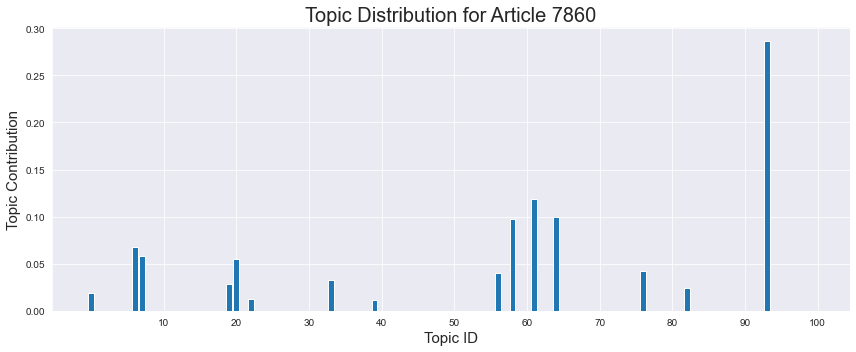

In [23]:
fig, ax = plt.subplots(figsize=(12,5));
# the histogram of the data
patches = ax.bar(np.arange(len(doc_distribution)), doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for Article " + str(random_article_index), fontsize=20)
ax.set_xticks(np.linspace(10,100,10))
fig.tight_layout()
plt.show()

In [24]:
# print the top 5 contributing topics and their words
for i in doc_distribution.argsort()[-5:][::-1]:
    print(i, lda.show_topic(topicid=i, topn=10), "\n")

93 [('british', 0.048411634), ('india', 0.04618613), ('minister', 0.04455518), ('european', 0.04396181), ('uk', 0.038144484), ('britain', 0.03473597), ('indian', 0.02511346), ('prime', 0.024735961), ('europe', 0.0222783), ('pakistan', 0.022020914)] 

61 [('year', 0.043747604), ('last', 0.018988136), ('time', 0.014783803), ('month', 0.014575398), ('since', 0.012493839), ('number', 0.010671582), ('rate', 0.010248711), ('high', 0.008603026), ('world', 0.007906303), ('next', 0.007844956)] 

64 [('would', 0.008414638), ('view', 0.0074383267), ('however', 0.00699636), ('example', 0.006942853), ('policy', 0.0068165553), ('point', 0.0064298958), ('also', 0.0060400795), ('current', 0.005797024), ('one', 0.005796635), ('fact', 0.005787944)] 

58 [('eu', 0.14134079), ('brexit', 0.12881023), ('england', 0.069884695), ('referendum', 0.055007674), ('london', 0.050153486), ('prayer', 0.04912009), ('persecution', 0.023132842), ('decision', 0.0195106), ('leave', 0.017633365), ('moron', 0.016824475)] 



Let's interpret this.

Topic 94  - Presidential Election

Topic 31 - Races

Topic 67 - Drug War

Topic 55 - God and Evil

Topic 38 - Scientific actions

These are rough interpretations for these topics, most of which make sense.

### Similarity Queries and Unseen Data

We will now turn our attention to the test set of data which the model has not yet seen. Although the articles in *test_df* have been unseen by the model, gensim has a way of infering their topic distributions given the trained model. Of course, the correct approach to yield accurate results would be to retrain the model with these new articles part of the corpus, but this can be timely and infeasable in a real case scenario where results are needed quickly.


In [81]:
# select and article at random from test_df
random_article_index = np.random.randint(len(test_df))
print(random_article_index)

780


In [82]:
new_bow = dictionary.doc2bow(test_df.iloc[random_article_index,7])

In [83]:
print(test_df.iloc[random_article_index,3])

  
Donald Trump is facing harsh criticism for the job he is doing as a citizen. 
"Wow, this guy won the election a whole week ago and he hasn't even started being president yet. What were we thinking?" said Skip Homeyer of the Whipperford Post website, adding that "he probably didn't even read the Constitution." 
NBC News, a news station with reporters and everything, complained that Trump "hadn't kept any of his campaign promises" and added that although "that was because he really hadn't done anything yet" that still was no excuse. 
Some of the people Trump has chosen to lead his team have also drawn harsh criticism from the media. Some of the names mentioned were Rudy Giuliani, Newt Gingrich, Adolph Hitler, Adolph Hitler's son and Cerberus. The last three were unofficial. 
"We expected much more from him. That's why none of us want him to take office" said one reporter who wanted to remain nameless, because he actually had no legal name. He then added that "people are getting fed up

In [84]:
new_doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=new_bow)])

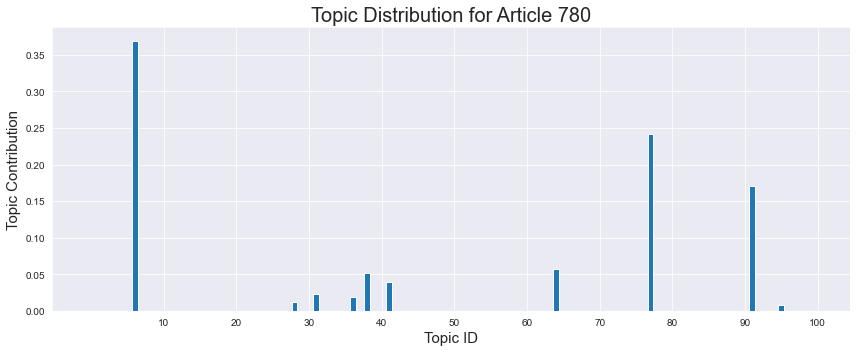

In [85]:
fig, ax = plt.subplots(figsize=(12,5));
# the histogram of the data
patches = ax.bar(np.arange(len(new_doc_distribution)), new_doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for Article " + str(random_article_index), fontsize=20)
ax.set_xticks(np.linspace(10,100,10))
fig.tight_layout()
plt.show()

In [86]:
# print the top 5 contributing topics and their words
for i in new_doc_distribution.argsort()[-5:][::-1]:
    print(i, lda.show_topic(topicid=i, topn=10), "\n")

6 [('like', 0.0149340555), ('know', 0.014722007), ('dont', 0.013500771), ('one', 0.012887221), ('get', 0.012861551), ('people', 0.012606216), ('going', 0.0120994), ('think', 0.010969056), ('thing', 0.010680198), ('say', 0.010144857)] 

77 [('trump', 0.1737071), ('donald', 0.044234797), ('election', 0.024539404), ('hillary', 0.019798728), ('american', 0.016206963), ('clinton', 0.016120812), ('president', 0.014565612), ('win', 0.01181988), ('america', 0.010583919), ('republican', 0.010257353)] 

91 [('medium', 0.035614472), ('news', 0.020730859), ('time', 0.014382548), ('new', 0.01327263), ('election', 0.012701669), ('journalist', 0.011868167), ('story', 0.011482576), ('campaign', 0.010097202), ('york', 0.009876495), ('report', 0.009414355)] 

64 [('would', 0.008414638), ('view', 0.0074383267), ('however', 0.00699636), ('example', 0.006942853), ('policy', 0.0068165553), ('point', 0.0064298958), ('also', 0.0060400795), ('current', 0.005797024), ('one', 0.005796635), ('fact', 0.005787944)]

An almost accurate topic distribution for an unseen document.

### Similarity Query   
We use the Jensen-Shannon distance metric to find the most similar documents. What the Jensen-Shannon distance tells us, is which documents are statisically "closer" (and therefore more similar), by comparing the divergence of their distributions. Jensen-Shannon is symmetric, unlike Kullback-Leibler on which the formula is based. This is good, because we want the similarity between documents A and B to be the same as the similarity between B and A.

The formula is described below.

For discrete distirbutions $P$ and $Q$, the Jensen-Shannon divergence, $JSD$ is defined as 
$$JSD\left(P||Q\right) = \frac{1}{2}D\left(P||M\right)+\frac{1}{2}D\left(Q||M\right)$$

where $M = \frac{1}{2}\left(P+Q\right)$  and $D$ is the Kullback-Leibler divergence   
The square root of the Jensen-Shannon divergence is the Jensen-Shannon Distance: $\sqrt{JSD\left ( P||Q\right )}$

**The smaller the Jensen-Shannon Distance, the more similar two distributions are (and in our case, the more similar any 2 documents are)**  

We can use the scipy implementation of entropy to do this. Entropy calculates the KL divergence.  
But first, we need to get all our LDA topic distributions into a dense matrix. This will enable fast and efficient computation.   
We will create a dense matrix, **doc_topic_dist**, of size  **𝑀×𝐾**  where  𝑀  is the number of documents and  𝐾  is the number of topics.

In [87]:
doc_topic_dist = np.array([[tup[1] for tup in lst] for lst in lda[corpus]])

In [88]:
doc_topic_dist.shape

(9510, 100)

In [89]:
def jensen_shannon(query, matrix):
    # This function implements a Jensen-Shannon similarity between the input query (an LDA topic distribution for a document)
    # and the entire corpus of topic distributions. 
    # It returns an array of length M where M is the number of documents in the corpus

    p = query.T # take transpose
    q = matrix.T # transpose matrix
    m = 0.5*(p + q)
    return np.sqrt(0.5*(entropy(p,m) + entropy(q,m)))
    #return (p.shape, q.shape)

In [90]:
def get_most_similar_documents(query, matrix, k=10):
    # This function implements the Jensen-Shannon distance above and 
    # returns the top k indices of the smallest jensen shannon distances
    sims = []
    for i in range(len(matrix)):
        sim = jensen_shannon(query,matrix[i])
        sims.append(sim)
    return np.array(sims).argsort()[:k]           # the top k positional index of the smallest Jensen Shannon distances

#### Most similar documents

We are comparing the new unseen document above to the entire corpus of ~10k documents to find which one is most similar to the new document.

How are we doing that? Well, we have the new documents LDA topic distribution in stored as varibale **new_doc_distribution**, and we have the entire corpus of documents topic distributions stored in the dense matrix **doc_topic_dist**. So now, we pass each row of **doc_topic_dist** through the Jensen-Shannon function above as the Q distribution, while the P distribution remains static as **new_doc_distribution**. Then we get the smallest distances and their corresponding index in the array, which we can pass to the **train_df** dataframe to print out the most similar documents.

In [91]:
# this is surprisingly fast
most_sim_ids = get_most_similar_documents(new_doc_distribution, doc_topic_dist)

In [92]:
most_similar_df = train_df[train_df.index.isin(most_sim_ids)]
most_similar_df['title']

859     ‘Right Before Hitler Killed Himself’: Trump In...
2458    Trump to star in ‘The President’ a new Reality...
2462    LOL! Remember When Obama Told Trump He’d Never...
2658    Pack Your Bags: 18 Celebs Who Said They Would ...
3291    Liberal MSNBC’s Chris Matthews Makes Unbelieva...
3779    AMERICANS DESPERATELY TRYING TO REMEMBER ELECT...
4146    Trump Haters Boycott Ivanka’s Clothing Line Be...
7760    Trump Mocks Biden's Dare To Take Him 'Behind t...
8327                                                     
9364    President-Elect Donald Trump's First Televised...
Name: title, dtype: object

I think we can see, the top most similar articles are quite similar indeed to the query article

Our query article is about Trump, his choices of team, Adolf Hitler and the election. The top 10 most similar documents in the corpus also contain these topics, as their title show above. The reader can print out the full articles, or visualise the topic distributions for the most similar document and compare them to the query document to check the overlap.

### Conclusion

- After cleaning the corpus and keeping only the top 20,000 words, we reduced the unique words in the corpus by 83%
- The LDA model was able to accurately identify different topics in the fake news corpus. We visually inspected these topics to see that the top words were related
- We were able to infer a topic distribution from a new unseen document
- We quickly retrieved the most similar documents in the trained corpus when comparing to the new unseen document. These most similar documents were in fact closely related to the query document